# Prototyping multiple catalog matching

I'm workshopping a function which will 

1. take in a list of catalogs, 
2. match them all against my photometry summary spreadsheet, and 
3. return a match table and a failure list.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import astropy.table
from astropy.coordinates import SkyCoord
from astropy import units as u

In [4]:
# let's load one table and match it.

aux_path = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/data/auxiliary_catalogs/NGC1333"
filepath = os.path.join(aux_path, "Scholz_2012ApJ_744_6S_table4.fit")

# load up our data.
table = astropy.table.Table.read(filepath)

# Do some catalog matching.
# (possibly: see https://docs.astropy.org/en/stable/coordinates/matchsep.html)

table_coordinates = SkyCoord(ra=table['RAJ2000'], dec=table['DEJ2000'])

table

ID,RAJ2000,DEJ2000,Jmag,Kmag,SpT1,SpT2,SpT3,SpT4,Teff1,Teff2,Teff3,Names,SimbadName,recno
,deg,deg,mag,mag,,,,,,,,,,
bytes16,float64,float64,float32,float32,bytes4,bytes4,bytes4,bytes4,int16,int16,int16,bytes17,bytes17,int32
SONYC-NGC1333-1,52.19858,31.36517,17.550,15.240,M9.2,,,,2600,2800,0,MBO139,SONYC NGC 1333-1,1
SONYC-NGC1333-2,52.22883,31.25806,15.990,14.219,M7.9,M6.5,M8,M8.6,2850,2600,0,"ASR109,Sp60",SONYC NGC 1333-2,2
SONYC-NGC1333-3,52.23017,31.29317,15.090,13.433,M7.9,M8.2,,,2900,0,0,ASR38,SONYC NGC 1333-3,3
SONYC-NGC1333-4,52.23542,31.26753,18.170,16.730,M9.6,,,,2500,0,0,,SONYC NGC 1333-4,4
SONYC-NGC1333-5,52.23725,31.34686,15.362,13.815,M7.6,M6,M6.8,,2850,2900,0,"MBO91,Sp66",SONYC NGC 1333-5,5
SONYC-NGC1333-6,52.23796,31.32000,17.240,15.340,M7.3,M8,M8.0,,3250,2700,0,"MBO148,ASR64,Sp23",SONYC NGC 1333-6,6
SONYC-NGC1333-7,52.24342,31.38242,15.399,13.685,M6.5,M7.1,M7.7,,2800,0,0,"MBO80,Sp72",SONYC NGC 1333-7,7
SONYC-NGC1333-8,52.26412,31.31108,15.833,14.000,M8.2,M8.5,M7.4,M8.4,2850,2600,0,"MBO88,ASR63,Sp80",SONYC NGC 1333-8,8


In [5]:
from wuvars.data import spreadsheet, photometry
from wuvars.plotting.lightcurve import simple_lc

spread = spreadsheet.load_wserv_v2(7)

In [6]:
w7m = spread['median']
spreadsheet_coordinates = SkyCoord(ra=w7m['RA'].values*u.rad, dec=w7m['DEC'].values*u.rad)


Relevant excerpt from the [Astropy Documentation](https://docs.astropy.org/en/stable/coordinates/matchsep.html):

```
>>> catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
>>> idx, d2d, d3d = c.match_to_catalog_sky(catalog)
```

Now `idx` are indices into `catalog` that are the closest objects to each of the coordinates in `c`, `d2d` are the on-sky distances between them, and `d3d` are the 3-dimensional distances. Because coordinate objects support indexing, `idx` enables easy access to the matched set of coordinates in the catalog:

```
>>> matches = catalog[idx]
>>> (matches.separation_3d(c) == d3d).all()
True
>>> dra, ddec = c.spherical_offsets_to(matches)
```

In [28]:
# this is the step that actually does the catalog matching.
# see this: https://docs.astropy.org/en/stable/coordinates/matchsep.html
idx, d2d, d3d = table_coordinates.match_to_catalog_sky(spreadsheet_coordinates)

print(idx)

matches = w7m.iloc[idx]
matches['Scholz_12a_ID'] = table['ID'].astype('str')

matches


[16882  8299 12467  8242 12488 12489 12523 12659  8609 12686 12707 12730
 12858 12803 12824  8222 13027 13054 13062  4336  8273  8295 12520 12761
 12916 12798  8215  8212 12588 16620 16820  4334  8275  8223  8187 12734
 12784 13085 12779 12921 12521]


/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,...,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR,JGRADE,HGRADE,KGRADE,Scholz_12a_ID
SOURCEID,,,,,,,,,,,,,,,,,,,,,
44508746127488,56243.003428,0.911037,0.547426,1.305519,0.057362,1.055950,0.035371,17.688057,0.045846,16.376614,...,0.016993,0.0,0.0,0.0,-1.0,0.999657,0.976589,0.978698,0.984756,SONYC-NGC1333-1
44508746107378,56243.985063,0.911565,0.545556,0.984506,0.025367,0.796278,0.023255,15.999459,0.013841,15.014597,...,0.010218,0.0,0.0,0.0,-1.0,0.999657,0.972727,0.969971,0.972603,SONYC-NGC1333-2
44508746116177,56243.004717,0.911589,0.546169,0.933076,0.022305,0.698038,0.021726,15.092044,0.010087,14.158556,...,0.008951,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.970909,0.983819,SONYC-NGC1333-3
44508746107277,56243.006218,0.911680,0.545721,0.670444,0.094827,0.723806,0.086828,18.203880,0.064769,17.547176,...,0.052142,0.0,0.0,0.0,-1.0,0.993865,0.972850,0.971681,0.972709,SONYC-NGC1333-4
44508746116243,56242.438047,0.911712,0.547106,0.865485,0.022902,0.666846,0.022163,15.395680,0.010804,14.528490,...,0.009408,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.971014,0.983819,SONYC-NGC1333-5
44508746116250,56242.438047,0.911724,0.546637,0.987822,0.036393,0.785534,0.030652,17.102942,0.024309,16.114918,...,0.015830,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.971014,0.983819,SONYC-NGC1333-6
44508746116316,56243.004717,0.911820,0.547727,0.969071,0.022534,0.696458,0.021848,15.261045,0.010448,14.291248,...,0.009081,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.970909,0.983819,SONYC-NGC1333-7
44508746116577,56242.438047,0.912181,0.546482,1.039554,0.023671,0.786359,0.022338,15.732491,0.011941,14.694439,...,0.009486,0.0,0.0,0.0,-1.0,0.944606,0.984791,0.971014,0.983819,SONYC-NGC1333-8
44508746107771,56243.985063,0.912339,0.544028,0.619228,0.042612,0.593308,0.041115,17.099171,0.027412,16.479126,...,0.024458,0.0,0.0,0.0,-1.0,0.999657,0.972727,0.969971,0.972603,SONYC-NGC1333-9


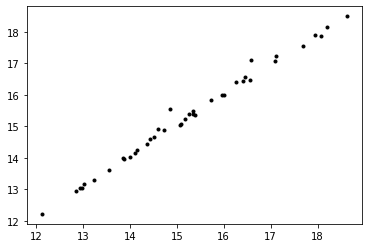

In [22]:
plt.plot(matches['JAPERMAG3'], table['Jmag'], 'k.')

In [29]:
# let's load one table and match it.

aux_path = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/data/auxiliary_catalogs/NGC1333"
filepath2 = os.path.join(aux_path, "Scholz_2012ApJ_744_6S_table2.fit")

# load up our data.
table2 = astropy.table.Table.read(filepath2)

# Do some catalog matching.
# (possibly: see https://docs.astropy.org/en/stable/coordinates/matchsep.html)

table2_coordinates = SkyCoord(ra=table2['RAJ2000'], dec=table2['DEJ2000'])

table2

_RAJ2000,_DEJ2000,SONYC,RAJ2000,DEJ2000,i_mag,z_mag,Jmag,Kmag,Av1,Av2,SpT,Teff,Names,Simbad,recno
deg,deg,,deg,deg,mag,mag,mag,mag,mag,mag,,K,,,
float64,float64,int16,float64,float64,float32,float32,float32,float32,int16,int16,bytes4,int16,bytes11,bytes6,int32
52.1183333,31.2742500,29,52.11833,31.27425,17.637,16.675,14.624,13.624,0,0,M6.9,3150,,Simbad,1
52.1295000,31.2844722,30,52.12950,31.28447,23.650,21.235,16.823,14.079,9,9,M9.3,2700,,Simbad,2
52.4339583,31.3299722,31,52.43396,31.32997,nan,nan,17.386,15.290,6,5,~M9,2300,Sp132,Simbad,3
52.2633750,31.4292222,32,52.26337,31.42922,nan,nan,15.798,13.832,4,4,M7.1,3200,"MBO89,Sp79",Simbad,4
52.2664583,31.3918889,33,52.26646,31.39189,nan,nan,17.143,14.932,7,5,M8.3,2500,"MBO116,Sp83",Simbad,5
52.2789167,31.4991944,34,52.27892,31.49919,20.839,19.225,16.541,14.774,4,4,M7.0,2950,Sp90,Simbad,6
52.2924167,31.4544444,35,52.29242,31.45444,18.988,17.711,15.547,14.127,2,2,M7.4,3050,"MBO94,Sp96",Simbad,7
52.3576667,31.2782778,36,52.35767,31.27828,23.392,21.432,18.530,17.070,2,0,~L3,2250,,Simbad,8


In [35]:
# let's first, independently, do some similar analysis with these new Scholz "Table 2" members

idx2, d2d2, d3d2 = table2_coordinates.match_to_catalog_sky(spreadsheet_coordinates)

print(idx2)

matches2 = w7m.iloc[idx2]
matches2['Scholz_12a_ID'] = [f"S-{x}" for x in table2['SONYC']]

matches2


[ 4557  4528 13166 12652 12663 12704 12738  8196 12991  8308]


/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,...,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR,JGRADE,HGRADE,KGRADE,Scholz_12a_ID
SOURCEID,,,,,,,,,,,,,,,,,,,,,
44508746098759,56241.524597,0.909638,0.545838,0.525908,0.021895,0.419386,0.021770,14.590139,0.009378,14.066149,...,0.009130,16.0,16.0,16.0,-1.0,0.999657,0.984568,0.971922,0.980843,S-29
44508746098719,56242.435403,0.909833,0.546017,1.753515,0.035148,1.321536,0.023606,17.055401,0.026786,15.300561,...,0.009708,0.0,0.0,0.0,-1.0,0.999657,0.981366,0.976190,0.982808,S-30
44508746117813,56242.438047,0.915145,0.546809,1.151014,0.049028,1.428943,0.033397,17.636654,0.036991,16.508480,...,0.014308,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.971014,0.983819,S-31
44508746116567,56242.438047,0.912168,0.548543,1.014158,0.023679,0.774596,0.022382,15.713297,0.011955,14.699318,...,0.009531,0.0,0.0,0.0,-1.0,0.944606,0.984791,0.971014,0.983819,S-32
44508746116585,56242.438047,0.912221,0.547893,1.278999,0.039015,1.047523,0.028439,17.306866,0.028482,16.026749,...,0.013269,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.971014,0.983819,S-33
44508746116723,56242.438047,0.912438,0.549764,0.906983,0.028580,0.765276,0.025888,16.516371,0.017053,15.610147,...,0.012530,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.970803,0.983819,S-34
44508746116825,56242.438047,0.912675,0.548983,0.728498,0.023158,0.557879,0.022637,15.449817,0.010992,14.722077,...,0.010022,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.971014,0.983819,S-35
44508746107164,56242.439617,0.913814,0.545908,0.653399,0.145606,0.733522,0.133789,18.688677,0.101940,18.020470,...,0.080625,0.0,0.0,0.0,-1.0,0.993865,0.973094,0.971731,0.972973,S-36
44508746117549,56243.004717,0.914156,0.549041,0.696785,0.021336,0.447361,0.021245,13.764425,0.008691,13.067463,...,0.008505,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.970909,0.983819,S-37


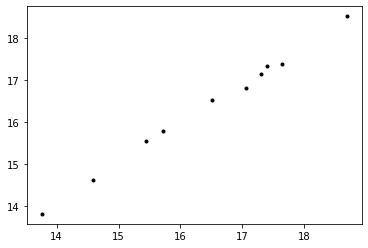

In [36]:
plt.plot(matches2['JAPERMAG3'], table2['Jmag'], 'k.')

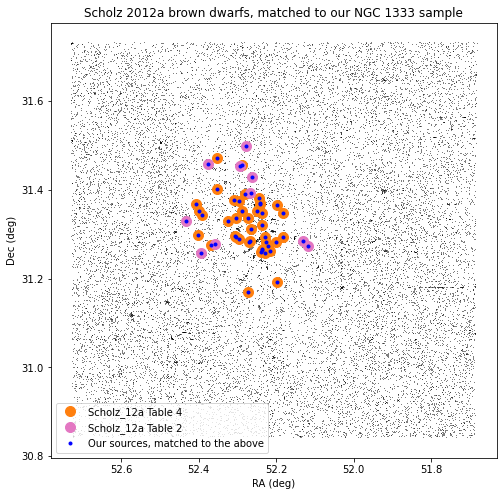

In [43]:
# did our catalog matching work? let's test it.

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.degrees(w7m['RA']), np.degrees(w7m['DEC']), 'k,', alpha=0.5)
ax.plot(table['RAJ2000'], table['DEJ2000'], 'C1o', ms=10, label='Scholz_12a Table 4')
ax.plot(table2['RAJ2000'], table2['DEJ2000'], 'C6o', ms=10, label='Scholz_12a Table 2')
ax.plot(np.degrees(w7m['RA'].values[idx]), np.degrees(w7m['DEC'].values[idx]), 'b.', label='Our sources, matched to the above')
ax.plot(np.degrees(w7m['RA'].values[idx2]), np.degrees(w7m['DEC'].values[idx2]), 'b.')
ax.legend()
ax.set_title("Scholz 2012a brown dwarfs, matched to our NGC 1333 sample")
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.invert_xaxis()

Text(0, 0.5, 'Number')

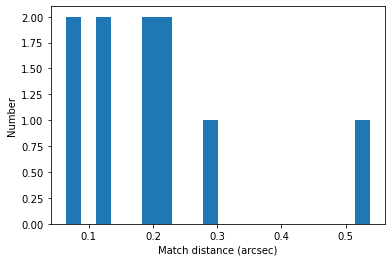

In [44]:
plt.hist(d2d2.to(u.arcsec).value, bins=20)
plt.xlabel("Match distance (arcsec)")
plt.ylabel("Number")

In [7]:
dat = photometry.group_wserv_v2(photometry.load_wserv_v2(7))
# dat = phot_grouped.wserv7

bd_match_sids = w7m.index[idx2]

for i, sid in enumerate(bd_match_sids):
    
    print(f"{i} S-{table2['SONYC'][i]} is {w7m.index[idx2[i]]}.")
    print(f" Match: {d2d2[i].to(u.arcsec):.2f}")
    print(f" Published mags: J={table2['Jmag'][i]:.1f}, K={table2['Kmag'][i]:.1f}")
    print(f" Measured mags:  J={w7m['JAPERMAG3'].values[idx2[i]]:.1f}, K={w7m['KAPERMAG3'].values[idx2[i]]:.1f}")
    print(f" Stetson variability index:  S={spread.wserv7['variability']['Stetson_JHK'].values[idx2[i]]:.2f}")
    print(" ")

    fig_lc = simple_lc(dat, sid)
    fig_lc.ax_j.set_title(f"{i} S-{table2['SONYC'][i]}. $S = {spread.wserv7['variability']['Stetson_JHK'].values[idx2[i]]:.2f}$")
    plt.show()
#     plt.savefig(f"Scholz_match_LCs/{i}_{table['ID'][i]}_{w7m.index[idx[i]]}")



Loading WSERV7 photometry data... DONE (elapsed time: 0.67s)


NameError: name 'idx2' is not defined

In [46]:
# let's load one table and match it.

aux_path = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/data/auxiliary_catalogs/NGC1333"
filepath3 = os.path.join(aux_path, "Scholz_2012ApJ_756_24S_table1.fit")

# load up our data.
table3 = astropy.table.Table.read(filepath3)

# Do some catalog matching.
# (possibly: see https://docs.astropy.org/en/stable/coordinates/matchsep.html)

table_coordinates3 = SkyCoord(ra=table3['RAJ2000'], dec=table3['DEJ2000'])

table3

_RAJ2000,_DEJ2000,SONYC,RAJ2000,DEJ2000,Jmag,Kmag,SpT,Av1,Av2,Teff,Cat,Simbad
deg,deg,,deg,deg,mag,mag,,mag,mag,K,,
float64,float64,int16,float64,float64,float32,float32,bytes4,int16,int16,int16,bytes6,bytes6
52.2290000,31.3042500,39,52.22900,31.30425,16.881,13.155,M8.5,15,17,2900,IZ,Simbad
52.2616667,31.3714722,40,52.26167,31.37147,16.959,13.423,M9.3,14,15,2700,JKS,Simbad
52.2692917,31.3413611,41,52.26929,31.34136,17.647,13.892,M7.6,15,18,3100,JKS,Simbad
52.3077083,31.3015833,42,52.30771,31.30158,19.252,17.540,L1,4,4,2400,IZ,Simbad
52.3414167,31.3081111,43,52.34142,31.30811,18.728,17.128,M8.1,3,5,2900,IZ,Simbad
52.2376667,31.2801944,44,52.23767,31.28019,nan,15.590,M8.6,0,4,2800,Random,Simbad
52.3043333,31.2939722,45,52.30433,31.29397,15.230,14.160,M8.1,0,2,2900,Random,Simbad


In [48]:
# let's first, independently, do some similar analysis with these new Scholz "Table 2" members

idx3, d2d3, d3d3 = table_coordinates3.match_to_catalog_sky(spreadsheet_coordinates)

print(idx3)

matches3 = w7m.iloc[idx3]
matches3['Scholz_12b_ID'] = [f"S-{x}" for x in table3['SONYC']]

matches3


[12460 12648 12691 12799 12880  8182 12784]


/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,...,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR,JGRADE,HGRADE,KGRADE,Scholz_12b_ID
SOURCEID,,,,,,,,,,,,,,,,,,,,,
44508746116168,56242.438047,0.911568,0.546363,2.643079,0.039575,1.671421,0.022156,17.475994,0.032126,14.832509,...,0.008730,0.0,0.0,16.0,-1.0,0.998679,0.984791,0.971014,0.983819,S-39
44508746116558,56242.438047,0.912138,0.547536,1.955095,0.030665,1.516428,0.022430,16.920006,0.021903,14.967948,...,0.008940,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.971014,0.983819,S-40
44508746116671,56242.438047,0.912270,0.547010,2.301433,0.046022,1.714995,0.023585,17.734049,0.039440,15.427980,...,0.009218,0.0,0.0,16.0,-1.0,0.999657,0.984791,0.971014,0.983819,S-41
44508746117027,56241.022895,0.912942,0.546316,0.904209,0.211318,0.870523,0.182711,19.411602,0.155948,18.547321,...,0.106934,0.0,0.0,0.0,-1.0,0.999657,0.984820,0.973171,0.983871,S-42
44508746117327,56241.527140,0.913531,0.546429,0.792370,0.127642,0.750934,0.114326,18.766823,0.092808,17.966320,...,0.070101,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.973105,0.983871,S-43
44508746107146,56243.005502,0.911719,0.545942,0.860324,0.038599,0.690662,0.033823,17.056101,0.026336,16.196552,...,0.018501,0.0,0.0,0.0,-1.0,0.900000,0.981096,0.971323,0.980545,S-44
44508746116999,56243.004717,0.912883,0.546183,0.507200,0.022675,0.498710,0.022563,15.165166,0.010241,14.658216,...,0.009997,0.0,0.0,0.0,-1.0,0.999657,0.984791,0.970909,0.983819,S-45


Text(0, 0.5, 'Number')

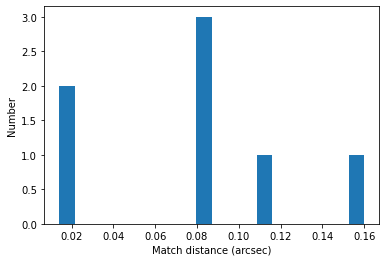

In [50]:
plt.hist(d2d3.to(u.arcsec).value, bins=20)
plt.xlabel("Match distance (arcsec)")
plt.ylabel("Number")

0 S-39 is 44508746116168.
 Match: 0.09 arcsec
 Published mags: J=16.9, K=13.2
 Measured mags:  J=17.5, K=13.2
 Stetson variability index:  S=1.05
 


/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


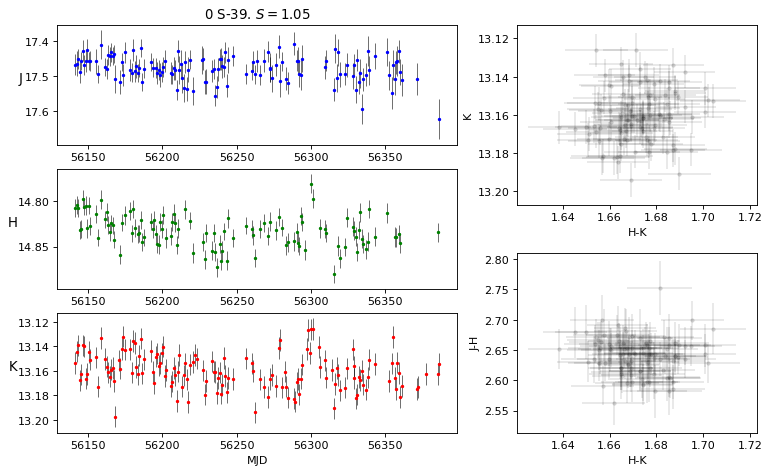

1 S-40 is 44508746116558.
 Match: 0.08 arcsec
 Published mags: J=17.0, K=13.4
 Measured mags:  J=16.9, K=13.5
 Stetson variability index:  S=2.21
 


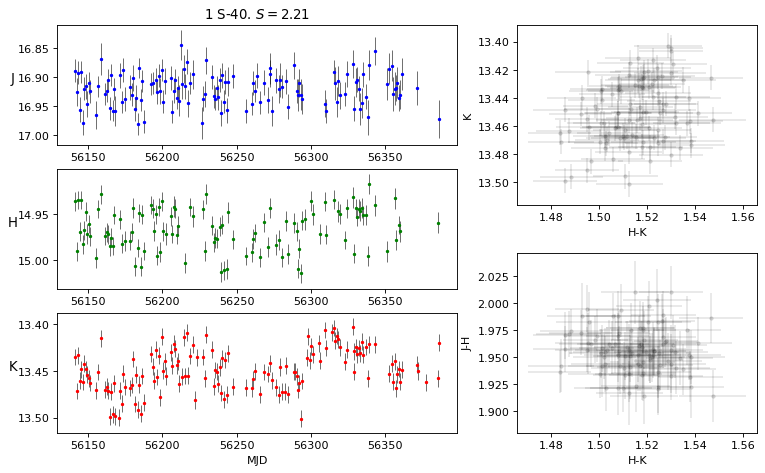

2 S-41 is 44508746116671.
 Match: 0.16 arcsec
 Published mags: J=17.6, K=13.9
 Measured mags:  J=17.7, K=13.7
 Stetson variability index:  S=0.69
 


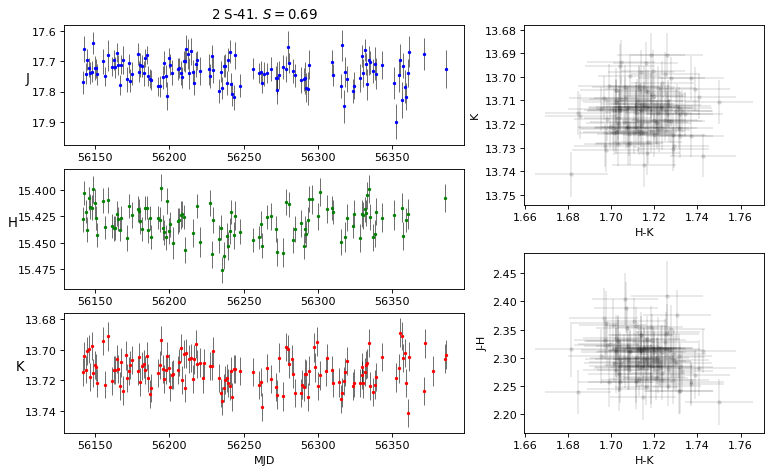

3 S-42 is 44508746117027.
 Match: 0.08 arcsec
 Published mags: J=19.3, K=17.5
 Measured mags:  J=19.4, K=17.7
 Stetson variability index:  S=-0.14
 


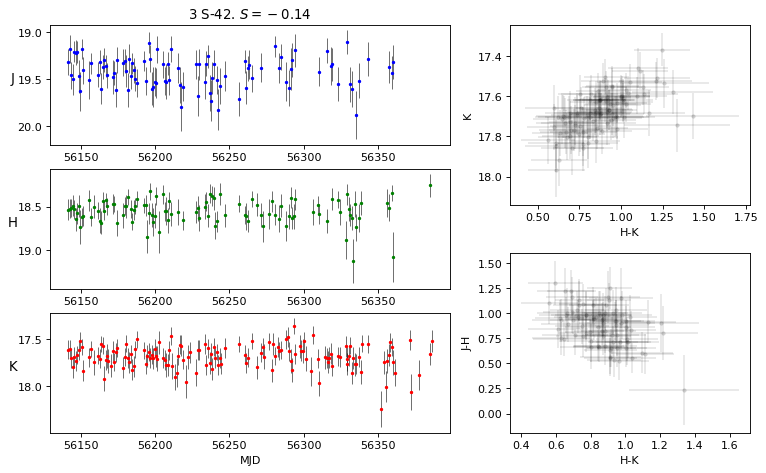

4 S-43 is 44508746117327.
 Match: 0.11 arcsec
 Published mags: J=18.7, K=17.1
 Measured mags:  J=18.8, K=17.2
 Stetson variability index:  S=-0.06
 


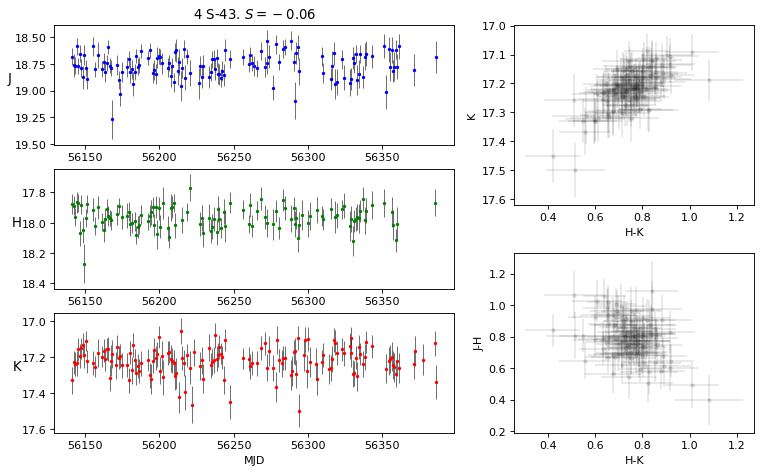

5 S-44 is 44508746107146.
 Match: 0.02 arcsec
 Published mags: J=nan, K=15.6
 Measured mags:  J=17.1, K=15.5
 Stetson variability index:  S=0.22
 


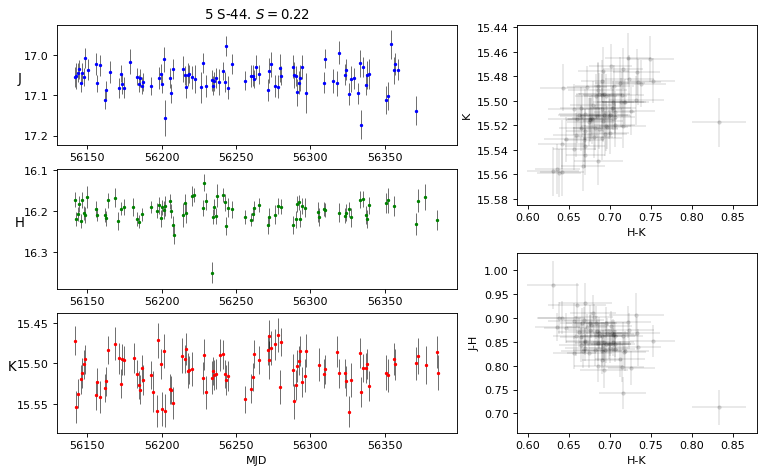

6 S-45 is 44508746116999.
 Match: 0.01 arcsec
 Published mags: J=15.2, K=14.2
 Measured mags:  J=15.2, K=14.2
 Stetson variability index:  S=0.60
 


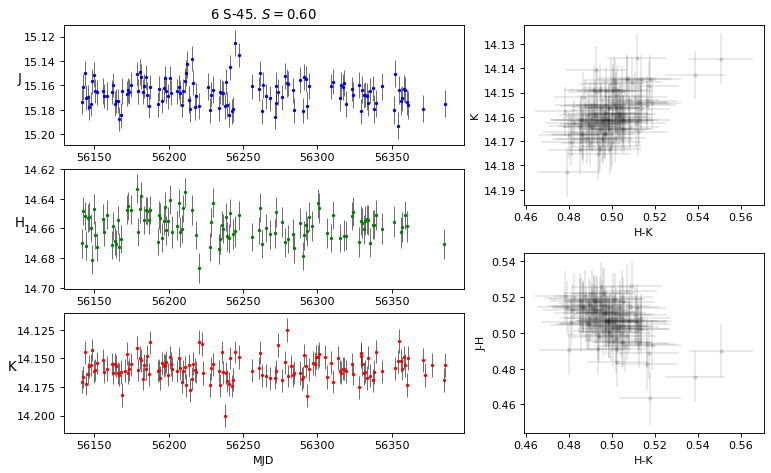

In [52]:
bd_match_sids = matches3.index

for i, sid in enumerate(bd_match_sids):
    
    print(f"{i} S-{table3['SONYC'][i]} is {sid}.")
    print(f" Match: {d2d3[i].to(u.arcsec):.2f}")
    print(f" Published mags: J={table3['Jmag'][i]:.1f}, K={table3['Kmag'][i]:.1f}")
    print(f" Measured mags:  J={matches3['JAPERMAG3'].values[i]:.1f}, K={matches3['KAPERMAG3'].values[i]:.1f}")
    print(f" Stetson variability index:  S={spread.wserv7['variability']['Stetson_JHK'].values[idx3[i]]:.2f}")
    print(" ")

    fig_lc = simple_lc(dat, sid)
    fig_lc.ax_j.set_title(f"{i} S-{table3['SONYC'][i]}. $S = {spread.wserv7['variability']['Stetson_JHK'].values[idx3[i]]:.2f}$")
    plt.show()
#     plt.savefig(f"Scholz_match_LCs/{i}_{table['ID'][i]}_{w7m.index[idx[i]]}")



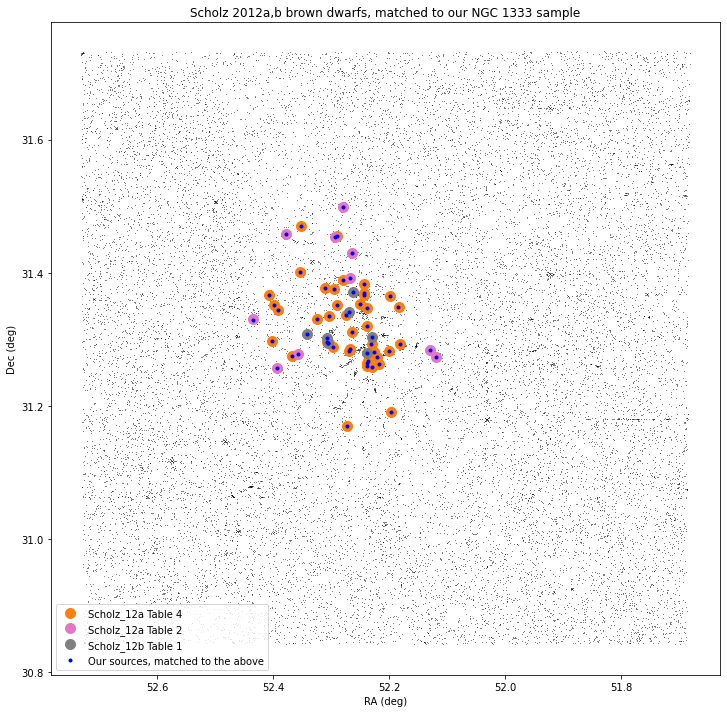

In [54]:
# did our catalog matching work? let's test it.

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(np.degrees(w7m['RA']), np.degrees(w7m['DEC']), 'k,', alpha=0.5)
ax.plot(table['RAJ2000'], table['DEJ2000'], 'C1o', ms=10, label='Scholz_12a Table 4')
ax.plot(table2['RAJ2000'], table2['DEJ2000'], 'C6o', ms=10, label='Scholz_12a Table 2')
ax.plot(table3['RAJ2000'], table3['DEJ2000'], 'C7o', ms=10, label='Scholz_12b Table 1')
ax.plot(np.degrees(w7m['RA'].values[idx]), np.degrees(w7m['DEC'].values[idx]), 'b.', label='Our sources, matched to the above')
ax.plot(np.degrees(w7m['RA'].values[idx2]), np.degrees(w7m['DEC'].values[idx2]), 'b.')
ax.plot(np.degrees(w7m['RA'].values[idx3]), np.degrees(w7m['DEC'].values[idx3]), 'b.')
ax.legend()
ax.set_title("Scholz 2012a,b brown dwarfs, matched to our NGC 1333 sample")
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.invert_xaxis()

# Design thoughts

Okay, so now that I've done this three times... I have some questions for myself.

1. What, fundamentally, do I need from my "matching" function? 
2. What, fundamentally, do I need to provide to my matching function?

I'll note that the three Scholz tables all had some things in common:
- their 
- they were all mutually exclusive! no item in one table also appeared in another table
- 

so there's a possibility I'll be constructing an intermediate "match" table which summarizes the following;